<a href="https://colab.research.google.com/github/irravasyuk/SQL_2/blob/master/%D0%94%D0%97_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [1]:
import pandas as pd

Дані медичне страхування

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [3]:
df.head()

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values).to(device)
      self.y = torch.FloatTensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

X = df.drop(columns=['expenses'])
y = df['expenses']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [27]:
from torch.utils.data import DataLoader

batch_size = 256
dataloader = DataLoader(dataset,  # датасет з даними
                        batch_size=batch_size,  # кількість даних в одному пакеті
                        shuffle=True,  # чи треба перемішувати дані
                        generator=torch.Generator(device=device)) # підключення до процесора)

In [28]:
X_batch, y_batch = next(iter(dataloader))

In [29]:
X_batch.shape

torch.Size([256, 5])

In [30]:
y_batch.shape

torch.Size([256, 1])

In [31]:
X_batch.device

device(type='cpu')

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [32]:
from torch import nn


model = nn.Sequential(
    nn.Linear(5, 7),
    nn.ReLU(),
    nn.Linear(7, 4),
    nn.ReLU(),
    nn.Linear(4, 3),
    nn.ReLU(),
    nn.Linear(3, 1)

)

model

Sequential(
  (0): Linear(in_features=5, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=3, bias=True)
  (5): ReLU()
  (6): Linear(in_features=3, out_features=1, bias=True)
)

In [33]:
from torchsummary import summary

summary(model, input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 7]              42
              ReLU-2                    [-1, 7]               0
            Linear-3                    [-1, 4]              32
              ReLU-4                    [-1, 4]               0
            Linear-5                    [-1, 3]              15
              ReLU-6                    [-1, 3]               0
            Linear-7                    [-1, 1]               4
Total params: 93
Trainable params: 93
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Завдання 4
Визначте функцію втрат та оптимізатор

In [34]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [35]:
import numpy as np

num_epochs = 10
losses = []

for epoch in range(num_epochs):
  losses_ = []
  for X_batch, y_batch in dataloader:
        # пряме поширення
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        # Зворотнє поширення
        loss.backward() # рахуємо градієнти
        optimizer.step()
        optimizer.zero_grad()

  losses.append(np.mean(losses_))

  if epoch % 1 == 0:
          print(f'loss={losses[-1]}')

loss=0.41928762197494507
loss=0.40472472707430523
loss=0.3910939047733943
loss=0.39371900260448456
loss=0.37489620844523114
loss=0.37200334171454114
loss=0.35734136402606964
loss=0.3543173124392827
loss=0.34180162847042084
loss=0.3330429444710414


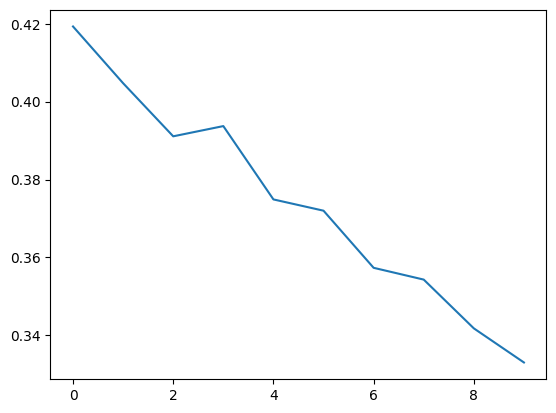

In [36]:
import matplotlib.pyplot as plt

plt.plot(losses)

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [37]:
torch.save(model, 'model.pt')

In [38]:
load_model = torch.load('model.pt')

In [39]:
load_model

Sequential(
  (0): Linear(in_features=5, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=3, bias=True)
  (5): ReLU()
  (6): Linear(in_features=3, out_features=1, bias=True)
)

In [40]:
X.iloc[:1]

,age,sex,bmi,children,smoker
0,0.021739,1,0.320755,0,1


In [41]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]])
torch.Size([1, 5])


In [42]:
load_model(X_data)

tensor([[-0.3556]], grad_fn=<AddmmBackward0>)